## Diabetes Prediction

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st

### Read Data

In [2]:
diabetes_df = pd.read_csv('diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv')
diabetes_df.head().T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,?,?,?,?,?
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1


### Data Wrangling

In [3]:
# Replace '?' in dataframe with pandas NA 
diabetes_df = diabetes_df.replace('?', pd.NA)
diabetes_df.head().T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,<NA>,<NA>,<NA>,<NA>,<NA>
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1


In [4]:
# Only keep the first encounter of the patient, because of the logistic regression
# Every data should be independent
diabetes_df = diabetes_df.drop_duplicates(subset='patient_nbr', keep='first')

In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      69570 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    2853 non-null   object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                40475 non-null  object
 11  medical_specialty         37041 non-null  object
 12  num_lab_procedures        71518 non-null  int64 
 13  num_procedures            71518 non-null  int64 
 14  num_medications      

Get some Statistics

In [6]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
encounter_id,71518.0,1.568156e+08,1.003769e+08,12522.0,81458068.5,144057399.0,2.155513e+08,443867222.0
patient_nbr,71518.0,5.505160e+07,3.947573e+07,135.0,23375767.5,48166798.5,8.752222e+07,189502619.0
admission_type_id,71518.0,2.100254e+00,1.508301e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,71518.0,3.593235e+00,5.269771e+00,1.0,1.0,1.0,3.000000e+00,28.0
admission_source_id,71518.0,5.657457e+00,4.162580e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,71518.0,4.289130e+00,2.949210e+00,1.0,2.0,3.0,6.000000e+00,14.0
num_lab_procedures,71518.0,4.307548e+01,1.995234e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,71518.0,1.430577e+00,1.759864e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,71518.0,1.570503e+01,8.311163e+00,1.0,10.0,14.0,2.000000e+01,81.0
number_outpatient,71518.0,2.800694e-01,1.068957e+00,0.0,0.0,0.0,0.000000e+00,42.0


In [7]:
#diabetes_df.drop(columns=['weight', 'encounter_id', ])
diabetes_df.describe(include='object').T

,count,unique,top,freq
race,69570,5,Caucasian,53491
gender,71518,3,Female,38025
age,71518,10,[70-80),18210
weight,2853,9,[75-100),1195
payer_code,40475,17,MC,20414
medical_specialty,37041,70,InternalMedicine,10919
diag_1,71507,696,414,5233
diag_2,71224,725,250,5009
diag_3,70293,758,250,9039
max_glu_serum,71518,4,None,68062


Race

In [8]:
# Replace NA values in race with missing
diabetes_df['race'] = diabetes_df['race'].replace(pd.NA, 'Missing')
print('Race Value Counts:')
print(diabetes_df['race'].value_counts())

Race Value Counts:
Caucasian          53491
AfricanAmerican    12887
Missing             1948
Hispanic            1517
Other               1178
Asian                497
Name: race, dtype: int64


Medical Specialty (Specialty of the admitting physician)

In [9]:
diabetes_df['medical_specialty'] = diabetes_df['medical_specialty'].replace(pd.NA, 'Missing')
# Keep the top five value
other = diabetes_df['medical_specialty'].value_counts().index[5:]
diabetes_df['medical_specialty'] = diabetes_df['medical_specialty'].replace(other, 'Other')
print('Medical Specialty Value Counts:')
print(diabetes_df['medical_specialty'].value_counts())

Medical Specialty Value Counts:
Missing                   34477
Other                     12273
InternalMedicine          10919
Family/GeneralPractice     5118
Emergency/Trauma           4465
Cardiology                 4266
Name: medical_specialty, dtype: int64


Diag 1 (Diagnosis)

In [10]:
diabetes_df['diag_1'] = diabetes_df['diag_1'].replace(pd.NA, '0')

diabetes_df.loc[diabetes_df['diag_1'].str.startswith('E') | diabetes_df['diag_1'].str.startswith('V'), 'diag_1'] = '1'

diabetes_df['diag_1'] = diabetes_df['diag_1'].astype('float')

diabetes_df['diagnosis'] = None

circulatory = ((diabetes_df['diag_1'] >= 390) & (diabetes_df['diag_1'] <= 459)) | (diabetes_df['diag_1'] == 785) 
diabetes_df.loc[circulatory, 'diagnosis'] = 'Circulatory'

respiratory = ((diabetes_df['diag_1'] >= 460) & (diabetes_df['diag_1'] <= 519)) | (diabetes_df['diag_1'] == 786)
diabetes_df.loc[respiratory, 'diagnosis'] = 'Respiratory'

digestive = ((diabetes_df['diag_1'] >= 520) & (diabetes_df['diag_1'] <= 579)) | (diabetes_df['diag_1'] == 787)
diabetes_df.loc[digestive, 'diagnosis'] = 'Digestive'

diabetes = ((diabetes_df['diag_1'] > 250) & (diabetes_df['diag_1'] < 251))
diabetes_df.loc[diabetes, 'diagnosis'] = 'Diabetes'

musculoskeletal = (diabetes_df['diag_1'] >= 800) & (diabetes_df['diag_1'] <= 999)
diabetes_df.loc[musculoskeletal, 'diagnosis'] = 'musculoskeletal'

genitourinary = ((diabetes_df['diag_1'] >= 580) & (diabetes_df['diag_1'] <= 629)) | (diabetes_df['diag_1'] == 788)
diabetes_df.loc[genitourinary, 'diagnosis'] = 'Genitourinary'

neoplasms = (diabetes_df['diag_1'] >= 140) & (diabetes_df['diag_1'] <= 239)
diabetes_df.loc[neoplasms, 'diagnosis'] = 'Neoplasms'

diabetes_df.loc[diabetes_df['diagnosis'].isna(), 'diagnosis'] = 'Other'

print('Diagnosis Value Counts:')
print(diabetes_df['diagnosis'].value_counts())

Diagnosis Value Counts:
Circulatory        21894
Other              16638
Respiratory         9776
Digestive           6570
Diabetes            5605
musculoskeletal     4779
Genitourinary       3514
Neoplasms           2742
Name: diagnosis, dtype: int64


Admission Source Id

In [11]:
other = diabetes_df['admission_source_id'].value_counts().index[2:]
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].replace(other, 'Other')
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].replace([7, 1], ['Emergency', 'Referral'])
print('Admission Source Value Counts:')
print(diabetes_df['admission_source_id'].value_counts())

Admission Source Value Counts:
Emergency    38290
Referral     22007
Other        11221
Name: admission_source_id, dtype: int64


HbA1c

In [12]:
high_changed = ((diabetes_df['A1Cresult'] == '>8') | (diabetes_df['A1Cresult'] == '>7')) & (diabetes_df['change'] == 'Ch')
high_notchanged = ((diabetes_df['A1Cresult'] == '>8') | (diabetes_df['A1Cresult'] == '>7')) & (diabetes_df['change'] == 'No')

diabetes_df.loc[high_changed, 'A1Cresult'] = 'High Changed'
diabetes_df.loc[high_notchanged, 'A1Cresult'] = 'High Not Changed'

print('HbA1c Value Counts')
print(diabetes_df['A1Cresult'].value_counts())

HbA1c Value Counts
None                58532
High Changed         5518
Norm                 3791
High Not Changed     3677
Name: A1Cresult, dtype: int64


Discharge

In [13]:
diabetes_df['discharge_disposition'] = None
diabetes_df.loc[diabetes_df['discharge_disposition_id'] > 1, 'discharge_disposition'] = 'Other'
diabetes_df.loc[diabetes_df['discharge_disposition_id'] == 1, 'discharge_disposition'] = 'Home'

diabetes_df['discharge_disposition'].value_counts()

Home     44317
Other    27201
Name: discharge_disposition, dtype: int64

Readmitted

In [14]:
diabetes_df['readmitted'] = diabetes_df['readmitted'].replace(['>30', '<30'], 1)
diabetes_df['readmitted'] = diabetes_df['readmitted'].replace('NO', 0)

diabetes_df['readmitted'].value_counts()

0    42985
1    28533
Name: readmitted, dtype: int64

### Data Visualization

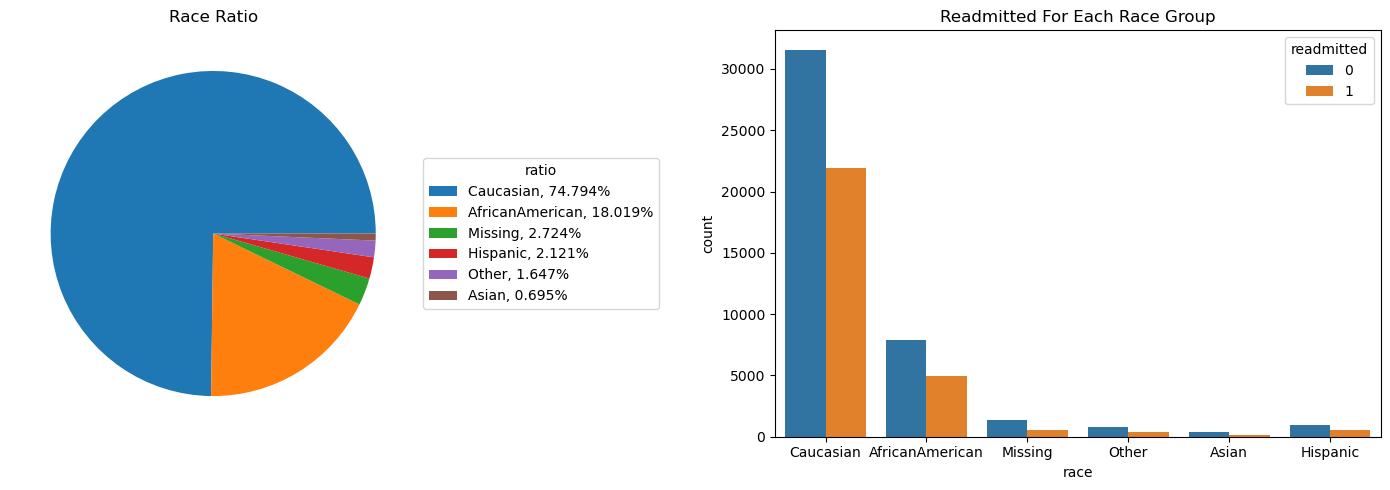

In [15]:
race_value_counts = diabetes_df['race'].value_counts()
labels = race_value_counts.index

labels = [f'{l}, {(s / sum(race_value_counts)*100):.3f}%' for l, s in zip(labels, race_value_counts)]

fig = plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(121)
explode = [0] * len(race_value_counts)
plt.pie(race_value_counts, explode=explode)
plt.title('Race Ratio')
plt.legend(labels=labels,
           title="ratio",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

plt.subplot(122)
plt.title('Readmitted For Each Race Group')
sns.countplot(data=diabetes_df, x='race', hue='readmitted')

plt.show()

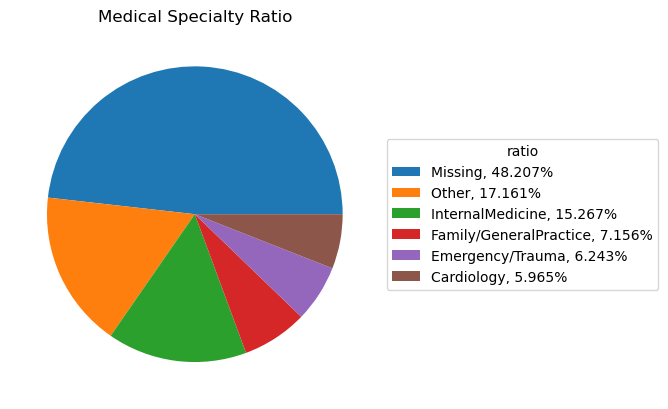

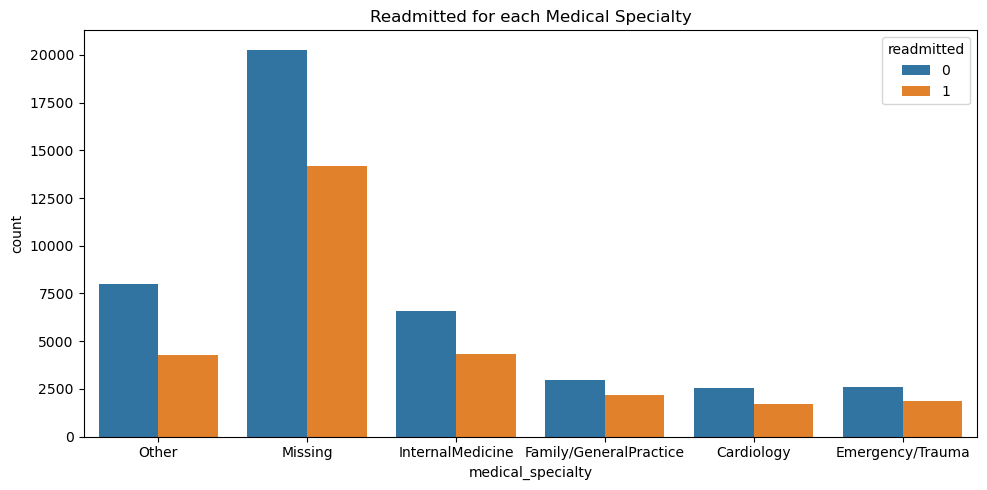

In [16]:
medical_specialty_value_counts = diabetes_df['medical_specialty'].value_counts()
labels = medical_specialty_value_counts.index

labels = [f'{l}, {(s / sum(medical_specialty_value_counts)*100):.3f}%' for l, s in zip(labels, medical_specialty_value_counts)]

explode = [0] * len(medical_specialty_value_counts)
wedges, texts = plt.pie(medical_specialty_value_counts, explode=explode)

plt.title('Medical Specialty Ratio')
plt.legend(labels=labels,
           title="ratio",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

plt.figure(figsize=(10, 5), tight_layout=True)
plt.title('Readmitted for each Medical Specialty')
sns.countplot(data=diabetes_df, x='medical_specialty', hue='readmitted')

plt.show()

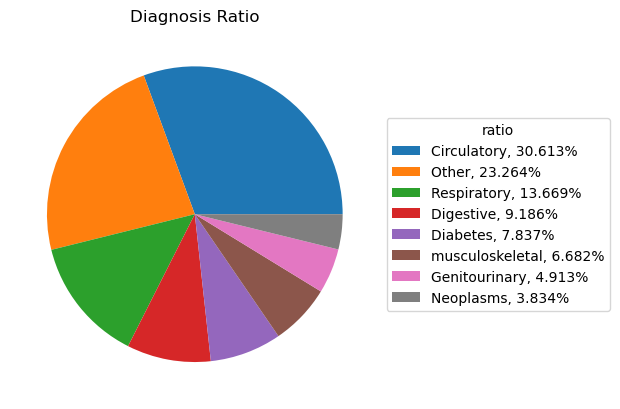

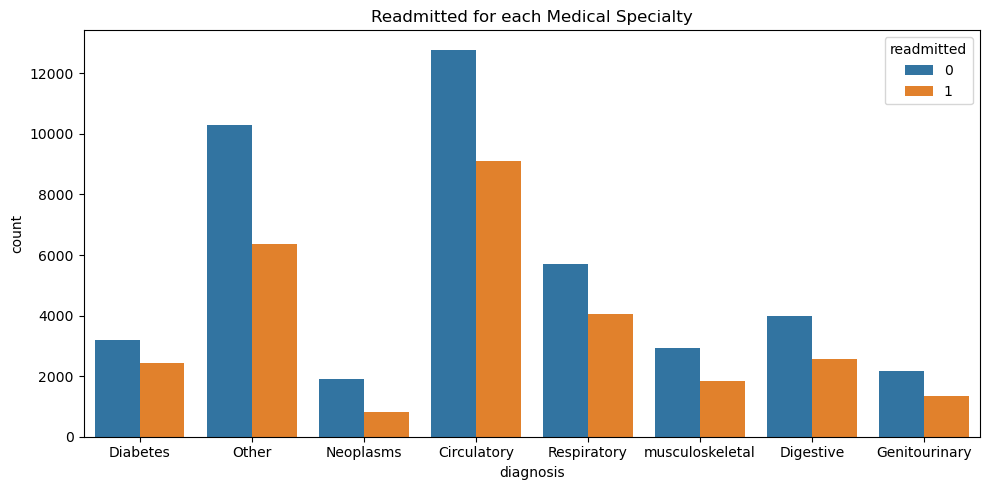

In [17]:
diagnosis_value_counts = diabetes_df['diagnosis'].value_counts()
labels = diagnosis_value_counts.index

labels = [f'{l}, {(s / sum(diagnosis_value_counts)*100):.3f}%' for l, s in zip(labels, diagnosis_value_counts)]

explode = [0] * len(diagnosis_value_counts)
wedges, texts = plt.pie(diagnosis_value_counts, explode=explode)

plt.title('Diagnosis Ratio')
plt.legend(labels=labels,
           title="ratio",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

plt.figure(figsize=(10, 5), tight_layout=True)
plt.title('Readmitted for each Medical Specialty')
sns.countplot(data=diabetes_df, x='diagnosis', hue='readmitted')

plt.show()

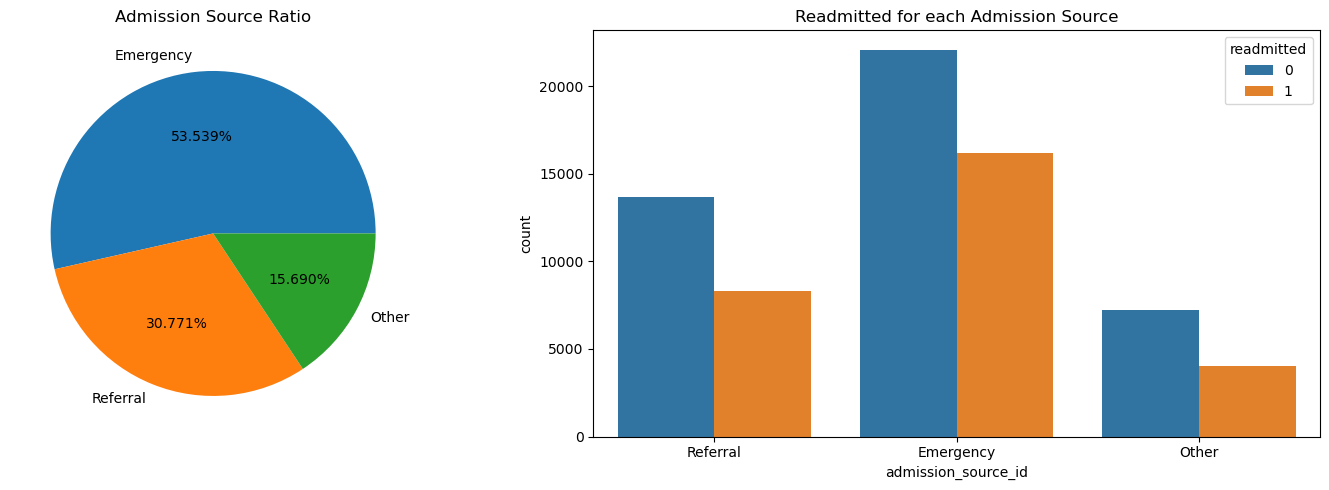

In [18]:
admission_value_counts = diabetes_df['admission_source_id'].value_counts()
labels = admission_value_counts.index

#labels = [f'{l}, {(s / sum(admission_value_counts)*100):.3f}%' for l, s in zip(labels, admission_value_counts)]

fig = plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(121)
explode = [0] * len(admission_value_counts)
plt.pie(admission_value_counts, labels=labels, explode=explode, autopct='%1.3f%%')

plt.title('Admission Source Ratio')

plt.subplot(122)
plt.title('Readmitted for each Admission Source')
sns.countplot(data=diabetes_df, x='admission_source_id', hue='readmitted')

plt.show()

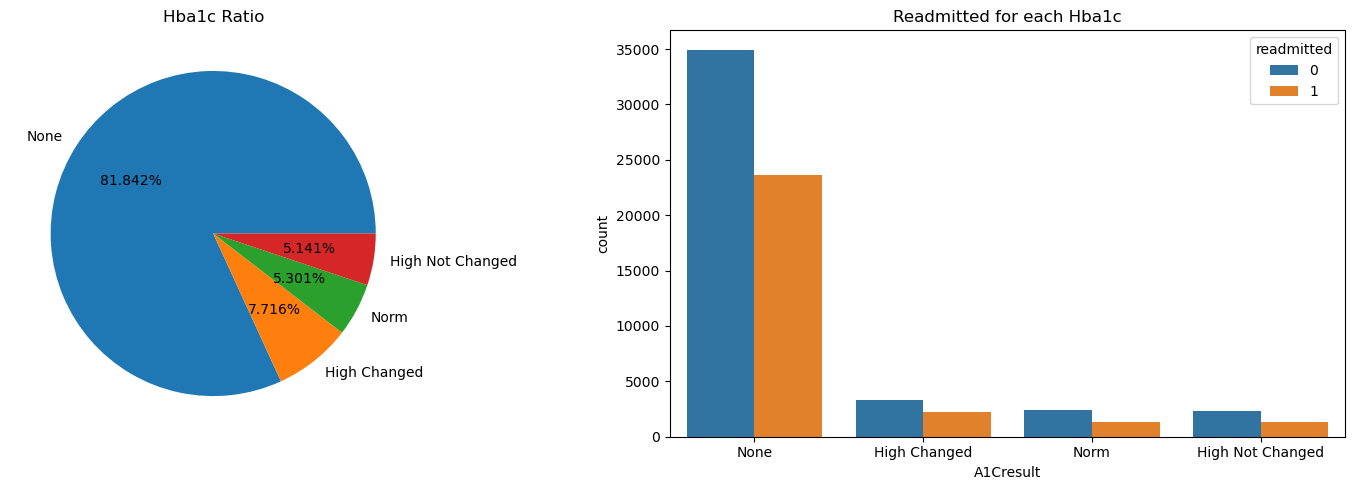

In [19]:
diabetes_df['A1Cresult'].value_counts()

HbA1c_value_counts = diabetes_df['A1Cresult'].value_counts()
labels = HbA1c_value_counts.index

#labels = [f'{l}, {(s / sum(admission_value_counts)*100):.3f}%' for l, s in zip(labels, admission_value_counts)]
fig = plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(121)
explode = [0] * len(HbA1c_value_counts)
plt.pie(HbA1c_value_counts, labels=labels, explode=explode, autopct='%1.3f%%')

plt.title('Hba1c Ratio')

plt.subplot(122)
plt.title('Readmitted for each Hba1c')
sns.countplot(data=diabetes_df, x='A1Cresult', hue='readmitted')

plt.show()

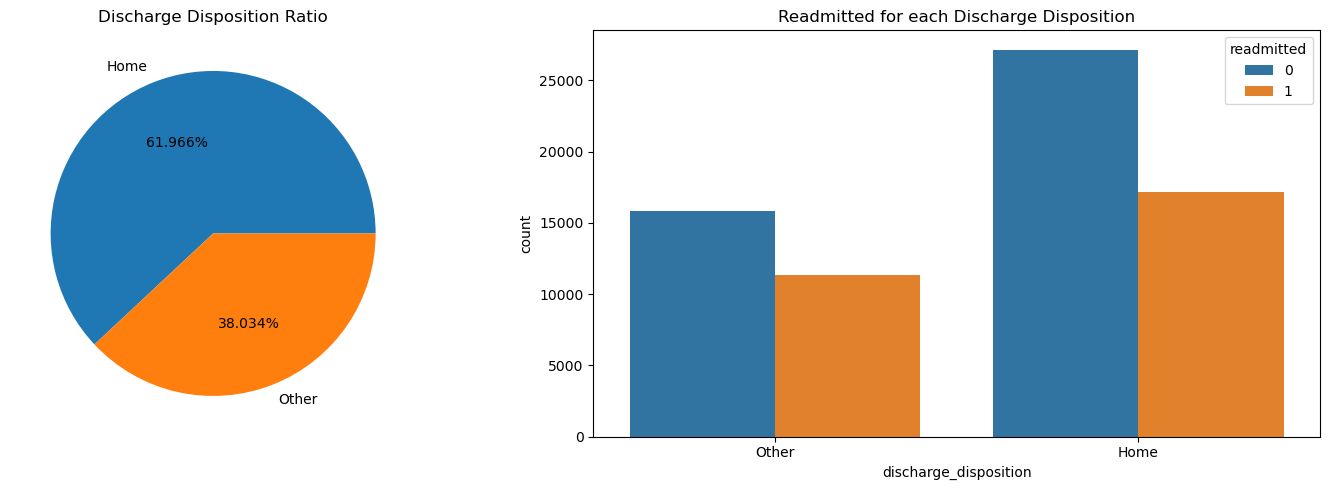

In [20]:
diabetes_df['discharge_disposition'].value_counts()

discharge_value_counts = diabetes_df['discharge_disposition'].value_counts()
labels = discharge_value_counts.index

#labels = [f'{l}, {(s / sum(admission_value_counts)*100):.3f}%' for l, s in zip(labels, admission_value_counts)]

plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(121)
explode = [0] * len(discharge_value_counts)
plt.pie(discharge_value_counts, labels=labels, explode=explode, autopct='%1.3f%%')

plt.title('Discharge Disposition Ratio')

plt.subplot(122)
plt.title('Readmitted for each Discharge Disposition')
sns.countplot(data=diabetes_df, x='discharge_disposition', hue='readmitted')

plt.show()

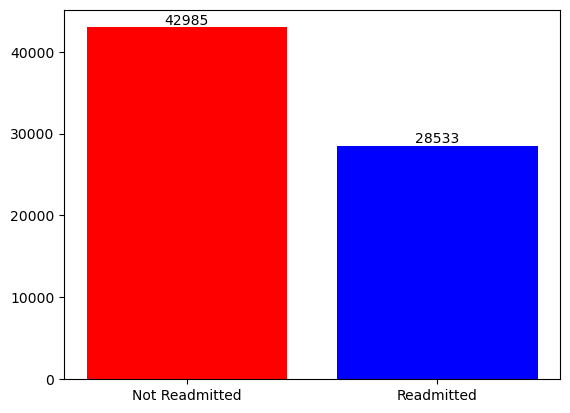

In [21]:
readmitted_value_counts = diabetes_df['readmitted'].value_counts()

labels = ['Not Readmitted', 'Readmitted']
plt.bar(labels, readmitted_value_counts, color=['r', 'b'])
for index, value in enumerate(readmitted_value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

[]

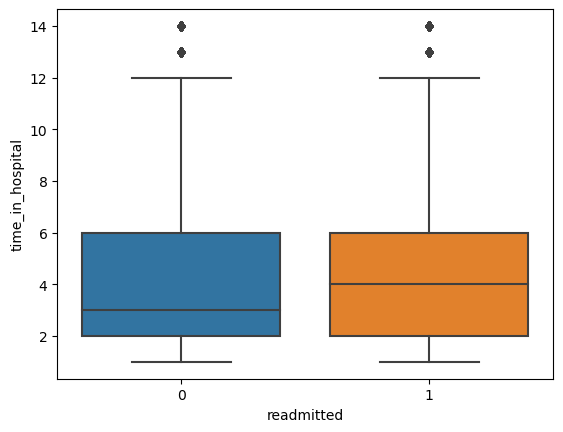

In [22]:
plt.title('')
sns.boxplot(data=diabetes_df, x="readmitted", y="time_in_hospital")
plt.plot()

### Prepare Data for Training

In [23]:
X_df = diabetes_df[['discharge_disposition', 'A1Cresult', 'admission_source_id', \
                    'diagnosis', 'medical_specialty', 'race', 'age', 'time_in_hospital']]

X_df.head(5)

,discharge_disposition,A1Cresult,admission_source_id,diagnosis,medical_specialty,race,age,time_in_hospital
0,Other,None,Referral,Diabetes,Other,Caucasian,[0-10),1
1,Home,None,Emergency,Other,Missing,Caucasian,[10-20),3
2,Home,None,Emergency,Other,Missing,AfricanAmerican,[20-30),2
3,Home,None,Emergency,Other,Missing,Caucasian,[30-40),2
4,Home,None,Emergency,Neoplasms,Missing,Caucasian,[40-50),1


In [24]:
X_df = pd.get_dummies(X_df)
Y_df = diabetes_df['readmitted']

X_df.head(5).T

,0,1,2,3,4
time_in_hospital,1,3,2,2,1
discharge_disposition_Home,0,1,1,1,1
discharge_disposition_Other,1,0,0,0,0
A1Cresult_High Changed,0,0,0,0,0
A1Cresult_High Not Changed,0,0,0,0,0
A1Cresult_None,1,1,1,1,1
A1Cresult_Norm,0,0,0,0,0
admission_source_id_Emergency,0,1,1,1,1
admission_source_id_Other,0,0,0,0,0
admission_source_id_Referral,1,0,0,0,0


### Start Classification

Logistic Regression

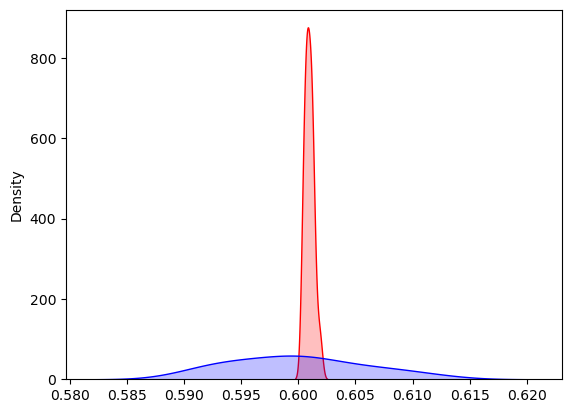

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

X = X_df.to_numpy()
y = Y_df.to_numpy()

skf = StratifiedKFold(n_splits=20)
train_accuracies, test_accuracies = [], []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    logistic_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    y_train_pred = logistic_reg.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    y_test_pred = logistic_reg.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

sns.kdeplot(train_accuracies, fill=True, color='r')
sns.kdeplot(test_accuracies, fill=True, color='b')
plt.show()